In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn import datasets
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

$$\text{Accuracy}$$

In [2]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

$$\text{Leaf class}$$

In [3]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.leaf_label = None
        self.prediction = self.predict()

    def predict(self):
        if self.leaf_label is None:            
            classes = {}
            for label in self.labels:
                if label not in classes:
                    classes[label] = 1
                else:
                    classes[label] += 1
            self.leaf_label = max(classes, key=classes.get)    
        return self.leaf_label

$$\text{Node class}$$

In [4]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


$$\text{Decision Tree Classifier class}$$

In [145]:
class Decision_Tree_Classifier:
    def __init__(self, criterion='gini', max_depth = None, min_samples_leaf = 1,
                 min_impurity_decrease = 0.0, homogeneous_leaf = True):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.homogeneous_leaf = homogeneous_leaf
        self.current_depth = 0
        
    def informative_criteria(self, labels):
        classes = {}
        diff = 1e-17
        for label in labels:
            if label not in classes:
                classes[label] = 1
            else:
                classes[label] += 1
        
        if self.criterion == 'gini':            
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p**2            
        elif self.criterion == 'shenon':
            impurity = 0
            for label in classes:
                p = classes[label]/ len(labels)
                if p == 0:
                    p = diff
                impurity -= p * np.log2(p)
        return impurity
    
    def quality(self, left_labels, right_labels, current_information):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        return current_information - p * self.informative_criteria(left_labels) - (1 - p) * self.informative_criteria(right_labels)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        
    def build_tree(self, data, labels):        
        quality, t, idx = self.find_best_split(data, labels)
        
        if quality == 0 or (len(set(labels)) == 1 and homogeneous_leaf):
            return Leaf(data, labels)
        
        self.current_depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
        self.quality_list.append(quality)
        
        if self.current_depth == self.max_depth:
            true_branch = Leaf(true_data, true_labels)
            false_branch = Leaf(false_data, false_labels)
            self.current_depth -= 1
            
        else:
            true_branch = self.build_tree(true_data, true_labels)
            false_branch = self.build_tree(false_data, false_labels)
        
        return Node(idx, t, true_branch, false_branch)
    
    def split(self, data, labels, idx, t):
        left_mask = data[:, idx] <= t
        
        true_data = data[left_mask]        
        true_labels = labels[left_mask]
        
        false_data = data[~left_mask]
        false_labels = labels[~left_mask]
        
        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):
        current_information = self.informative_criteria(labels)
        
        best_quality = 0
        best_t = None
        best_idx = None
        
        n_features = data.shape[1]
        
        for idx in range(n_features):
            t_values = np.unique(data[:, idx])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
                
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue
                
                current_quality = self.quality(true_labels, false_labels, current_information)
                
                if current_quality > best_quality and abs(current_quality - best_quality) > self.min_impurity_decrease:
                    best_quality, best_t, best_idx = current_quality, t, idx
                
        return best_quality, best_t, best_idx
    
    def classify_object(self, obj, node):
        if isinstance(node, Leaf):
            return node.prediction
        
        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
    def predict(self, data):
        classes = np.zeros(len(data))
        for i, obj in enumerate(data):
            classes[i] = self.classify_object(obj, self.tree)
        return classes
            

$$\text{Print Tree function}$$

In [6]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'
    
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + ' УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

$$\text{Metrics expected via Confusion Matrix}$$

In [7]:
def confusion_matrix(y, y_pred):    
    mask_ones = y == 1
    mask_zero = y == 0
    
    #Calculus TP
    TP = sum(y_pred[mask_ones] == 1)
    #Calculus TN
    TN = sum(y_pred[mask_zero] == 0)
    #Calculus FP
    FP = sum(y_pred[mask_zero] == 1)
    #Calculus FN
    FN = len(y) - TP - TN - FP
    
    conf_matrix = np.array([[TP, FP], [FN, TN]])
    return conf_matrix
    

def accuracy(conf_matrix):
    n = sum(conf_matrix.ravel())
    return (conf_matrix[0, 0] + conf_matrix[1, 1])/n

def precision(conf_matrix):
    return conf_matrix[0, 0]/sum(conf_matrix[0, :])

def recall(conf_matrix):
    return conf_matrix[0, 0]/sum(conf_matrix[:, 0])

def f1(conf_matrix):
    prec, rec = precision(conf_matrix), recall(conf_matrix)
    return 2*(prec*rec)/(prec+rec)
    



In [102]:
# генерация данных
classification_data, classification_labels = datasets.make_classification(n_samples = 500,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state = 4)

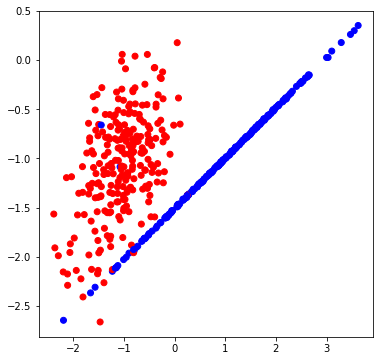

In [103]:
# визуализация данных

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [106]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [42]:
dcl = Decision_Tree_Classifier(min_samples_leaf = 5)
dcl.fit(train_data, train_labels)
train_predicted = dcl.predict(train_data)
test_predicted = dcl.predict(test_data)
accuracy_metric(train_labels, train_predicted), accuracy_metric(test_labels, test_predicted)

(98.85714285714286, 94.66666666666667)

In [ ]:
print_tree(dcl.tree)

### <b> Task №2

In [104]:
#params: max_depth, min_samples_leaf, criterion, min_impurity_decrease, homogeneous_leaf

max_depths = np.array([5, 10, 20])
min_samples_leafs = np.array([5, 7, 10, 12, 15, 17, 20])
metrics = np.array([accuracy, precision, recall, f1])
criterions = np.array(['gini', 'shenon'])

n, m, amount_of_metrics = len(max_depths), len(min_samples_leafs), len(metrics)

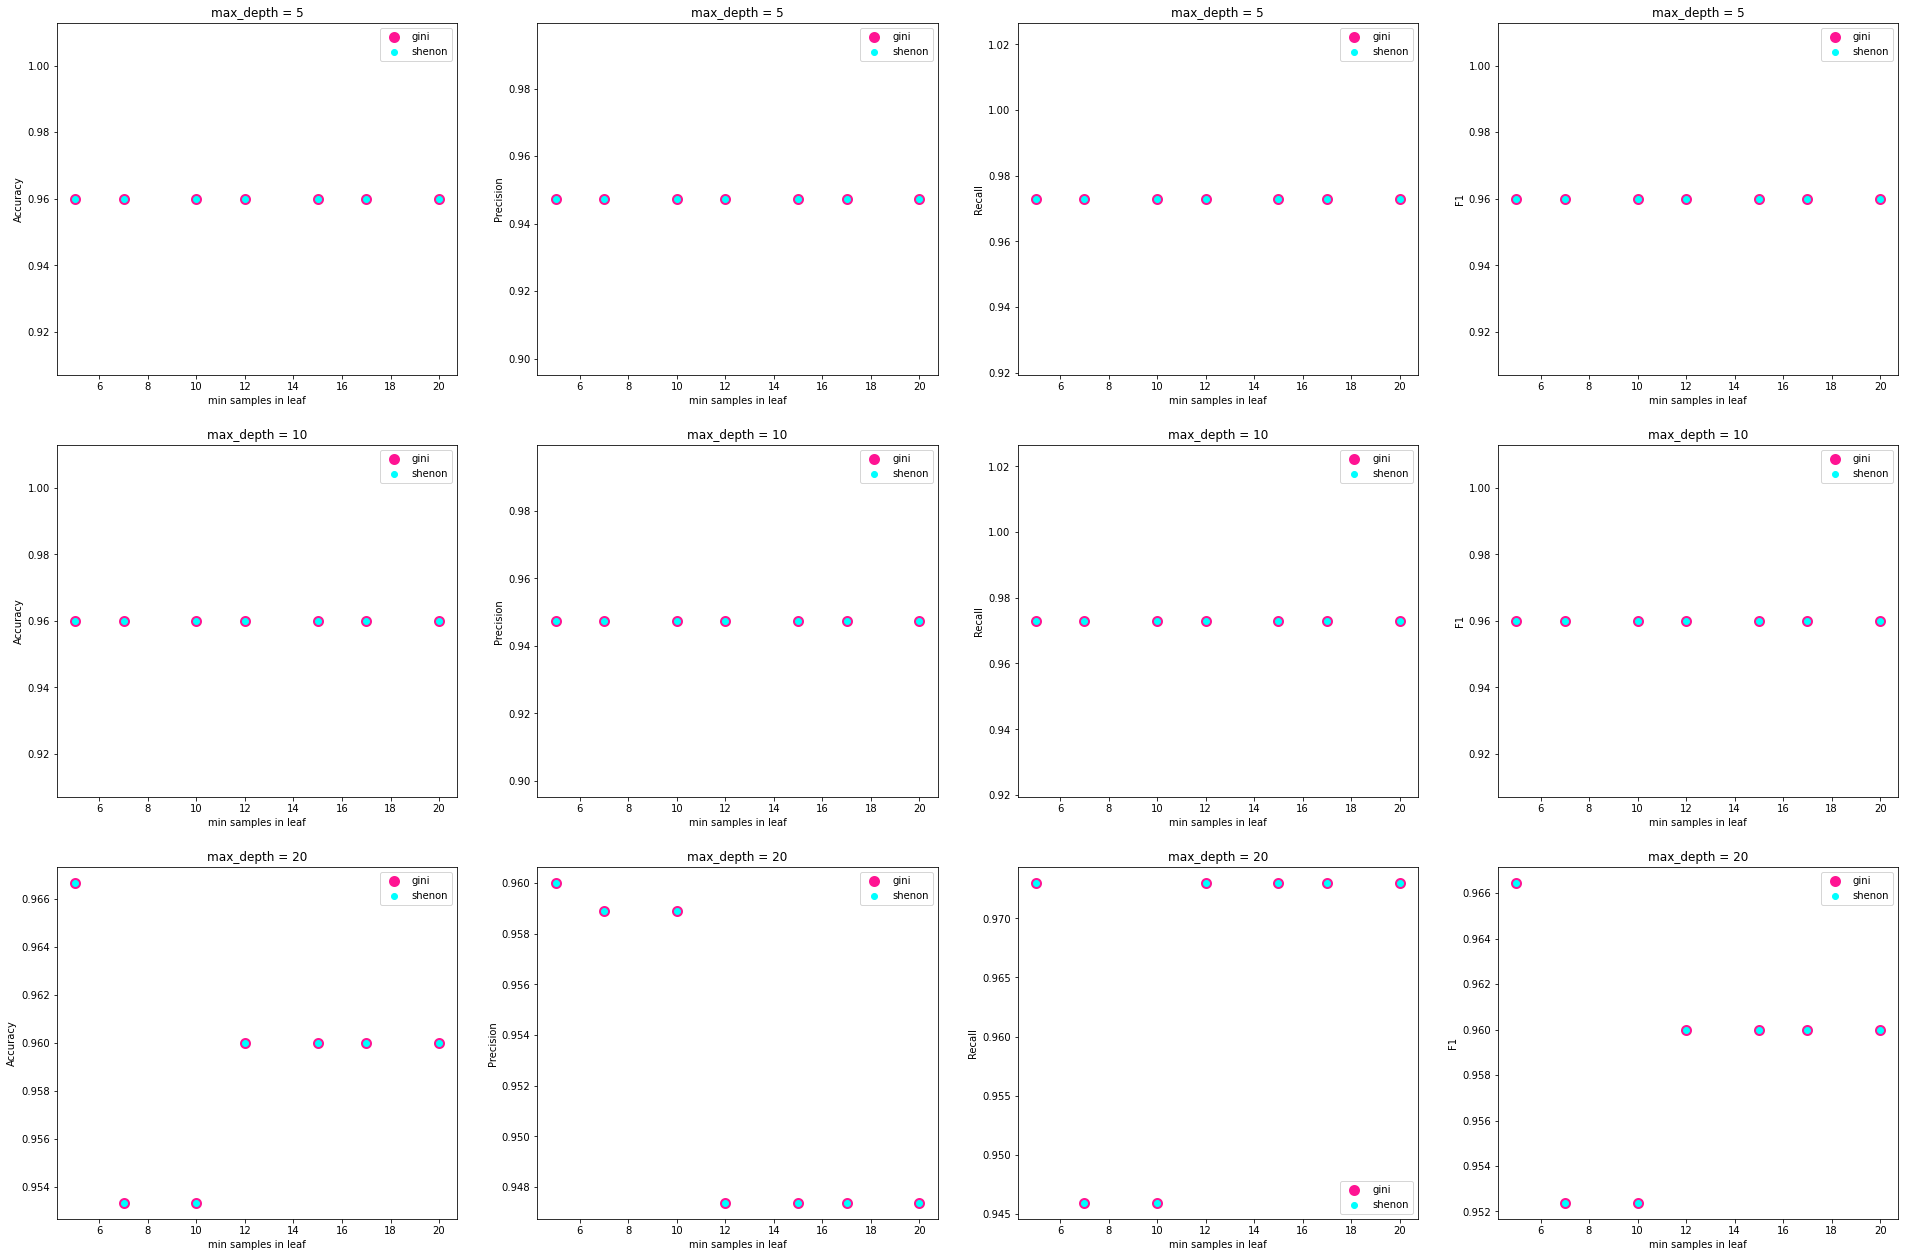

In [107]:
#metrics: accuracy, precision, recall, f1, 
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
metrics_list = [accuracy_list, precision_list, recall_list, f1_list]

fig, ax = plt.subplots(n, amount_of_metrics, figsize = (7*n + (m-1)*2, (n-1) + 5*amount_of_metrics))

for i in range(n):    
    for j in range(m):        
        for criterion in criterions:
            dcl = Decision_Tree_Classifier(criterion = criterion, max_depth = max_depths[i], min_samples_leaf = min_samples_leafs[j])
            dcl.fit(train_data, train_labels)
            test_predicted = dcl.predict(test_data)
            conf_matrix = confusion_matrix(test_labels, test_predicted)
            for k in range(amount_of_metrics):
                metrics_list[k].append(metrics[k](conf_matrix))
    for k in range(amount_of_metrics):
        ax[i, k].set_xlabel('min samples in leaf')
        ax[i, k].set_ylabel(f'{metrics[k].__name__.title()}')
        ax[i, k].set_title(f'max_depth = {max_depths[i]}')
        ax[i, k].scatter(min_samples_leafs, metrics_list[k][0::2], label = 'gini', color = '#FF1493', linewidth = 5)
        ax[i, k].scatter(min_samples_leafs, metrics_list[k][1::2], label = 'shenon', color = '#00FFFF')
        ax[i, k].legend()
        metrics_list[k].clear()

* Метрики $accuracy$, $precision$, $recall$, $F1$ не меняют своего значения, если изменить способ подсчёта критерия информативности. Вполне логично, если учесть, что оба критерия оценивают однородность данных. Допустим перед нами два мастера своего дела. Например, сапожники. Конечный продукт — отремонтированные ботинки — признаются качественными, но разница в технологии их ремонта. Поэтому, чтобы увидеть, как на метрики влияет выбор критерия — нужно следить за самой "технологией", т.е. за изменением функции качества — будем варьировать $\text{min_impurity_decrease}$.

In [108]:
#params: max_depth, min_samples_leaf, criterion, min_impurity_decrease, homogeneous_leaf

max_depths = np.array([5, 10, 20])
min_impurity_decrease = np.logspace(-5, 0, 6)
metrics = np.array([accuracy, precision, recall, f1])
criterions = np.array(['gini', 'shenon'])

n, m, amount_of_metrics = len(max_depths), len(min_impurity_decrease), len(metrics)

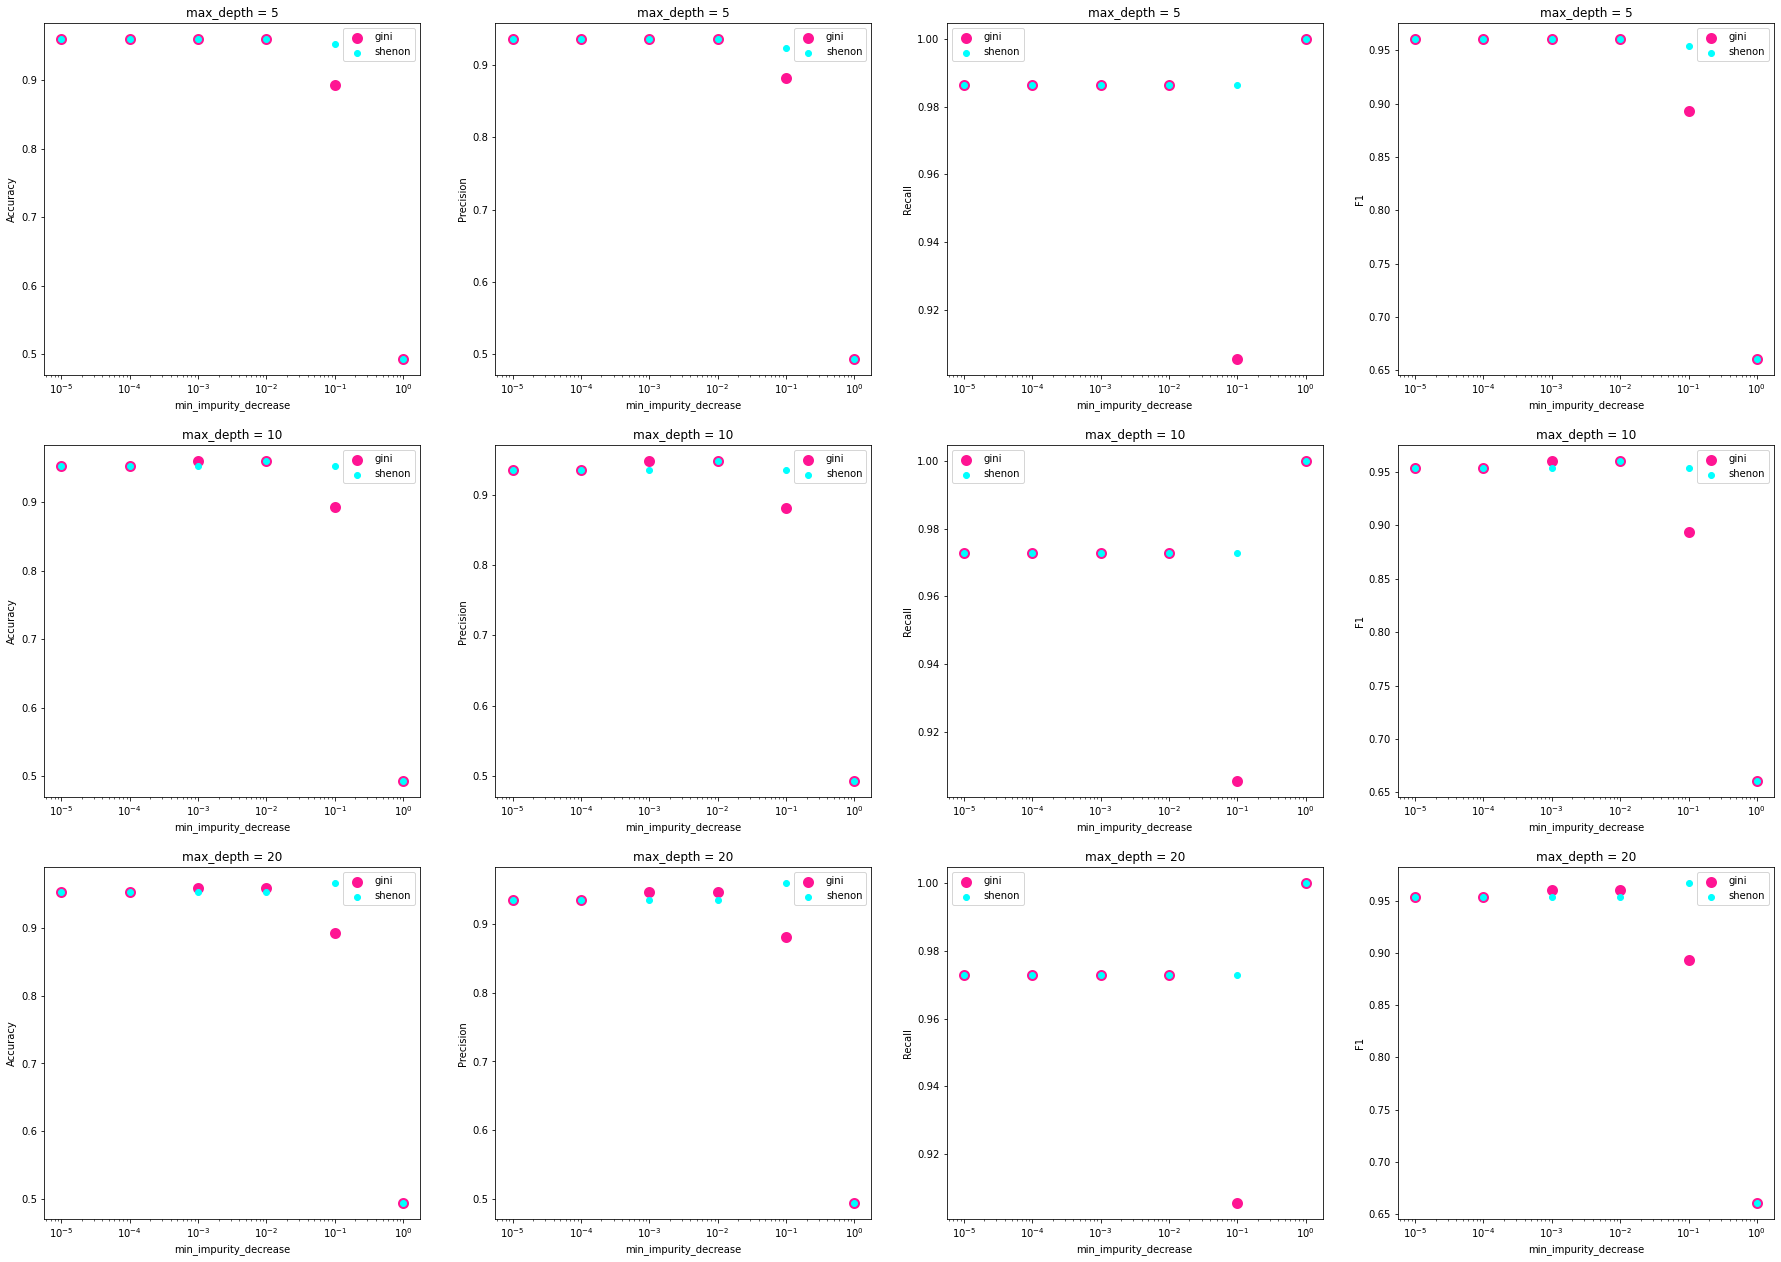

In [109]:
#metrics: accuracy, precision, recall, f1, 
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
metrics_list = [accuracy_list, precision_list, recall_list, f1_list]

fig, ax = plt.subplots(n, amount_of_metrics, figsize = (7*n + (m-1)*2, (n-1) + 5*amount_of_metrics))

for i in range(n):    
    for j in range(m):        
        for criterion in criterions:
            dcl = Decision_Tree_Classifier(criterion = criterion, max_depth = max_depths[i], min_samples_leaf = 1, min_impurity_decrease = min_impurity_decrease[j])
            dcl.fit(train_data, train_labels)
            test_predicted = dcl.predict(test_data)
            conf_matrix = confusion_matrix(test_labels, test_predicted)
            for k in range(amount_of_metrics):
                metrics_list[k].append(metrics[k](conf_matrix))
    for k in range(amount_of_metrics):
        ax[i, k].set_xscale('log')
        ax[i, k].set_xlabel('min_impurity_decrease')
        ax[i, k].set_ylabel(f'{metrics[k].__name__.title()}')
        ax[i, k].set_title(f'max_depth = {max_depths[i]}')
        ax[i, k].scatter(min_impurity_decrease, metrics_list[k][0::2], label = 'gini', color = '#FF1493', linewidth = 5)
        ax[i, k].scatter(min_impurity_decrease, metrics_list[k][1::2], label = 'shenon', color = '#00FFFF')
        ax[i, k].legend()
        metrics_list[k].clear()

* Изменения есть, но никаких выводов сделать пока нельзя. Построим графики изменения индексов Джини и Шенона. Будем считать, что решаем задачу бинарной классификации (в многоклассовом случае будем использовать подход $\text{1 vs others}$).

In [124]:
x = np.linspace(1e-7, 1-1e-7, endpoint = True)

In [125]:
gini = lambda x: 1 - (x**2 + (1-x)**2)
shenon = lambda x: -x*np.log2(x) - (1-x)*np.log2(1-x)

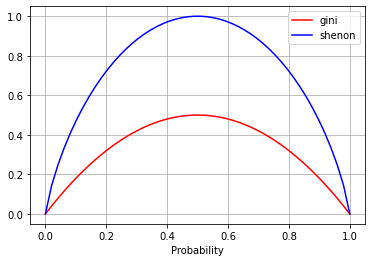

In [132]:
plt.plot(x, gini(x), label = 'gini', color = 'red')
plt.plot(x, shenon(x), label = 'shenon', color = 'blue')
plt.xlabel('Probability')
plt.legend()
plt.grid()
plt.show()

* Область значений индекса Джини $[0; 0.5]$.
* Область значений энтропии Шенона $[0; 1]$ 
* Минимальное значение этих индексов гарантируют наибольшую однородность данных, т.е. когда в лист вошли объекты из одного класса. Максимальное соответствует обратной ситуации.
* Увеличим каждое значение индекса Джини в 2 раза и посмотрим на сколько будут отличаться графики.

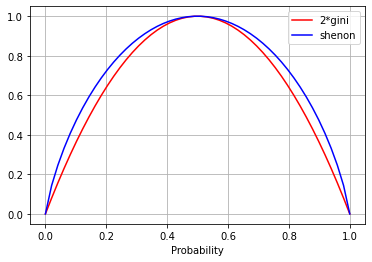

In [137]:
plt.plot(x, 2*gini(x), label = '2*gini', color = 'red')
plt.plot(x, shenon(x), label = 'shenon', color = 'blue')
plt.xlabel('Probability')
plt.legend()
plt.grid()
plt.show()

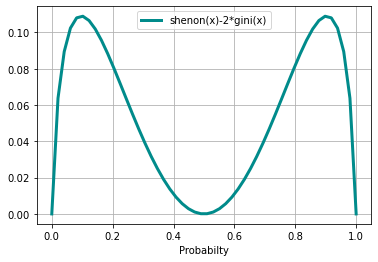

In [139]:
plt.plot(x, shenon(x)-2*gini(x), label = fr'shenon(x)-2*gini(x)', color = 'darkcyan', linewidth = 3)
plt.xlabel('Probabilty')
plt.grid()
plt.legend()
plt.show()

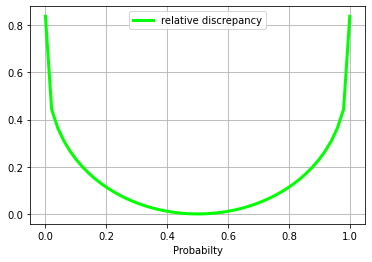

In [142]:
relative_discr = (shenon(x)-2*gini(x))/shenon(x)
plt.plot(x, relative_discr, label = 'relative discrepancy', color = 'lime', linewidth = 3)
plt.xlabel('Probabilty')
plt.grid()
plt.legend()
plt.show()

In [143]:
print(np.mean(relative_discr), np.std(relative_discr, ddof = 1))

0.14627816893401463 0.1874142700293882


* Значения этих индексов зависят практически линейно, т.е. из энтропийного значения можно получить индекс Джини, домножив энтропию на $\frac{1}{2}$. Относительная невязка такой замены не превышает $15$% в случаях, когда относительная частота класса в листе варьируется в интервале $[0.2; 0.8]$.
* Поэтому, с точки зрения построения дерева, выбор критерия <b>практически</b> не важен. Вопрос в оптимизации: с точки зрения вычисления самих индексов, Джини значительно проще, ведь использует только суммирование и возведение в степень на одном шаге, в то время как расчёт энтропии требует вычисления $log_2(p_k)$, а это уже разложение в ряд Тейлора, т.е. значительно больше элементарных действий, следовательно больше времени на обучение дерева.


### <b> Task №3

$$\text{Leaf for regression}$$

In [162]:
class Leaf_Regressor(Leaf):
    def predict(self):
        if self.leaf_label is None:            
            self.leaf_label = np.mean(self.labels)  
        return self.leaf_label

$$\text{Decision Tree Regressor}$$

In [191]:
class Decision_Tree_Regressor:
    def __init__(self, criterion = 'dispersion', max_depth = None, min_samples_leaf = 1, min_dispersion_decrease = 0.0, homogeneous_leaf = True):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_dispersion_decrease = min_dispersion_decrease
        self.homogeneous_leaf = homogeneous_leaf
        self.current_depth = 0
        
    def informative_criteria(self, labels): 
        if self.criterion == 'dispersion':
            if len(labels) == 1:
                impurity = 0
            else:                
                impurity = np.var(labels, ddof = 1)
        return impurity
    
    def quality(self, left_labels, right_labels, current_information):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        return current_information - p * self.informative_criteria(left_labels) - (1 - p) * self.informative_criteria(right_labels)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        
    def build_tree(self, data, labels):        
        quality, t, idx = self.find_best_split(data, labels)
        
        if quality == 0 or (len(set(labels)) == 1 and homogeneous_leaf):
            return Leaf_Regressor(data, labels)
        
        self.current_depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
        
        if self.current_depth == self.max_depth:
            true_branch = Leaf_Regressor(true_data, true_labels)
            false_branch = Leaf_Regressor(false_data, false_labels)
            self.current_depth -= 1
            
        else:
            true_branch = self.build_tree(true_data, true_labels)
            false_branch = self.build_tree(false_data, false_labels)
        
        return Node(idx, t, true_branch, false_branch)
    
    def split(self, data, labels, idx, t):
        left_mask = data[:, idx] <= t
        
        true_data = data[left_mask]        
        true_labels = labels[left_mask]
        
        false_data = data[~left_mask]
        false_labels = labels[~left_mask]
        
        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):
        current_information = self.informative_criteria(labels)
        
        best_quality = 0
        best_t = None
        best_idx = None
        
        n_features = data.shape[1]
        
        for idx in range(n_features):
            t_values = np.unique(data[:, idx])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
                
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue
                
                current_quality = self.quality(true_labels, false_labels, current_information)
                
                if current_quality > best_quality and abs(current_quality - best_quality) > self.min_dispersion_decrease:
                    best_quality, best_t, best_idx = current_quality, t, idx
                
        return best_quality, best_t, best_idx
    
    def classify_object(self, obj, node):
        if isinstance(node, Leaf_Regressor):
            return node.prediction
        
        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
    def predict(self, data):
        predictions = np.zeros(len(data))
        for i, obj in enumerate(data):
            predictions[i] = self.classify_object(obj, self.tree)
        return predictions
            

$$\text{MAE}$$

In [202]:
def calc_mae(y, y_pred):
    return np.sum(np.abs(y-y_pred))/len(y)

$$\text{MSE}$$

In [203]:
def calc_mse(y, y_pred):
    return np.sum((y-y_pred)**2)/len(y)

In [218]:
#генерация данных
regression_data, target, coef = datasets.make_regression(n_samples=20, 
                                      n_features=2, 
                                      n_informative=2, 
                                      n_targets=1,
                                      noise=5, 
                                      coef=True, 
                                      random_state=42)

In [219]:
#разбиение на train-test
train_data, test_data, train_labels, test_labels = train_test_split(regression_data, 
                                                                    target, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [220]:
dtr = Decision_Tree_Regressor()
dtr.fit(train_data, train_labels)

In [221]:
dtr = Decision_Tree_Regressor()
dtr.fit(train_data, train_labels)
test_predict = dtr.predict(test_data)

In [222]:
mse, mae = calc_mse(test_labels, test_predict), calc_mae(test_labels, test_predict)

In [223]:
print(f'MSE: {mse}, \tRMSE: {mse**0.5}')
print(f'MAE: {mae}')

MSE: 12356.767540224595, 	RMSE: 111.16099828727968
MAE: 96.37197305904442
